# 1 Instalations

In [8]:
!pip install pandas langdetect 

  Using cached langdetect-1.0.9-py3-none-any.whl


In [9]:
#pip install pytorch-accelerated

In [10]:
#pip install git+https://github.com/huggingface/accelerate

# 2 Imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from langdetect import detect
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
import torch
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import re  

2024-05-30 20:19:36.033961: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 20:19:36.034061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 20:19:36.159518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
# Download the stopwords ancorpus and punk tokenizer models from the NLTK library
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup

# 3 Load and Preview

In [14]:
# Paths for train and test data
train_path = '/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt'
test_path = '/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt'

# Load datasets with defined seperation between columns
train_data = pd.read_csv(train_path, sep=':::', engine='python', names=['Title', 'Genre', 'Description'])
test_data = pd.read_csv(test_path, sep=':::', engine='python', names=['Title', 'Genre', 'Description'])

# Preview datasets
print(train_data.head())
print(test_data.head())


                                Title       Genre  \
1       Oscar et la dame rose (2009)       drama    
2                       Cupid (1997)    thriller    
3   Young, Wild and Wonderful (1980)       adult    
4              The Secret Sin (1915)       drama    
5             The Unrecovered (2007)       drama    

                                         Description  
1   Listening in to a conversation between his do...  
2   A brother and sister with a past incestuous r...  
3   As the bus empties the students for their fie...  
4   To help their unemployed father make ends mee...  
5   The film's title refers not only to the un-re...  
                           Title          Genre  \
1          Edgar's Lunch (1998)       thriller    
2      La guerra de papá (1977)         comedy    
3   Off the Beaten Track (2010)    documentary    
4        Meu Amigo Hindu (2015)          drama    
5             Er nu zhai (1955)          drama    

                                         Des

# 4 Summary Statistics 

In [15]:
# Summary statistics for both train and test data
print(train_data.describe())
print(train_data.info())
print(test_data.describe())
print(test_data.info())

# Check for duplicate descriptions
description_counts_train = train_data['Description'].value_counts()
description_counts_test = test_data['Description'].value_counts()

# Find repeating descriptions
repeating_descriptions_train = description_counts_train[description_counts_train > 1]
repeating_descriptions_test = description_counts_test[description_counts_test > 1]

# Based on fined repeting description filter repeating descriptions
repeating_descriptions_df_train = train_data[train_data['Description'].isin(repeating_descriptions_train.index)].sort_values(by='Description')
repeating_descriptions_df_test = test_data[test_data['Description'].isin(repeating_descriptions_test.index)].sort_values(by='Description')

print(repeating_descriptions_df_train[['Title', 'Description']])
print(repeating_descriptions_df_test[['Title', 'Description']])


                                               Title    Genre  \
count                                          54214    54214   
unique                                         54214       27   
top      Nature's Fury: Storm of the Century (2006)    drama    
freq                                               1    13613   

                                              Description  
count                                               54214  
unique                                              54086  
top      Grammy - music award of the American academy ...  
freq                                                   12  
<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None
                     

### 4.1 Genre Distribution Plot

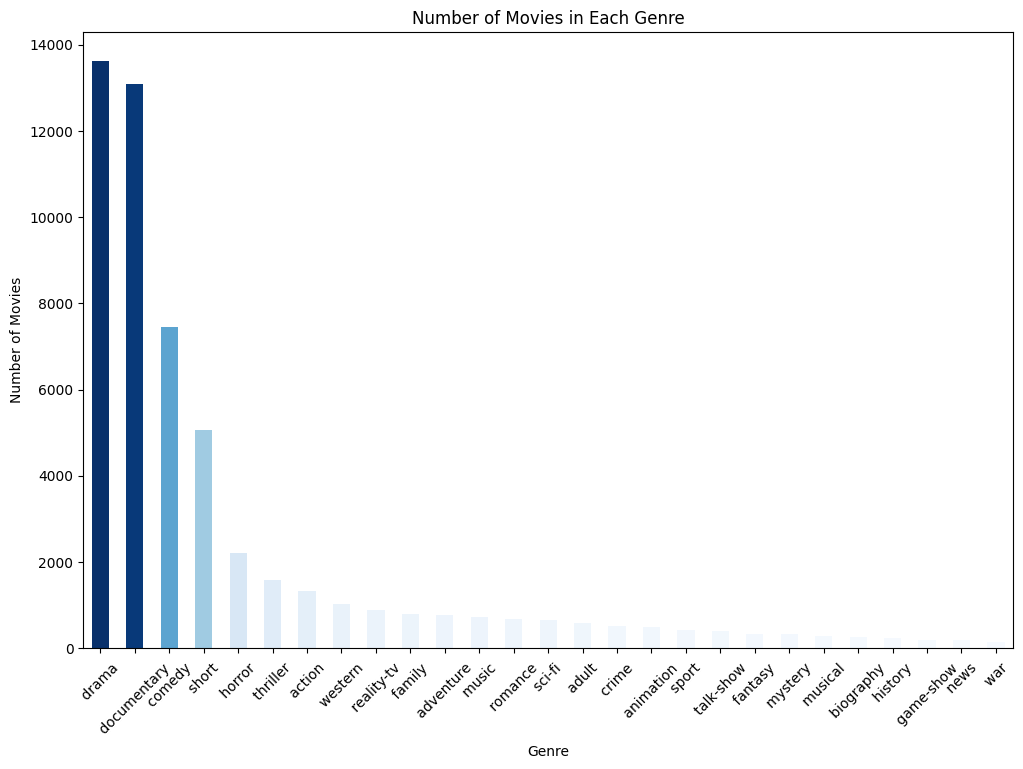

In [16]:
import matplotlib.colors as mcolors

# Plot the distribution of genres
# Calculating the count of each genre in the 'Genre' column of the train_data
genre_counts = train_data['Genre'].value_counts()
# Normalizing the genre counts to create a colormap range
norm = mcolors.Normalize(vmin=0.003*genre_counts.max(), vmax=genre_counts.max())
color_map = plt.get_cmap('Blues')
#Applying the colormap to the genre counts to generate corresponding colors
colors = [color_map(norm(count)) for count in genre_counts]

#Plotting genres
plt.figure(figsize=(12, 8))
genre_counts.plot(kind='bar', color=colors)
plt.title('Number of Movies in Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()


### 4.2 Description Length Distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


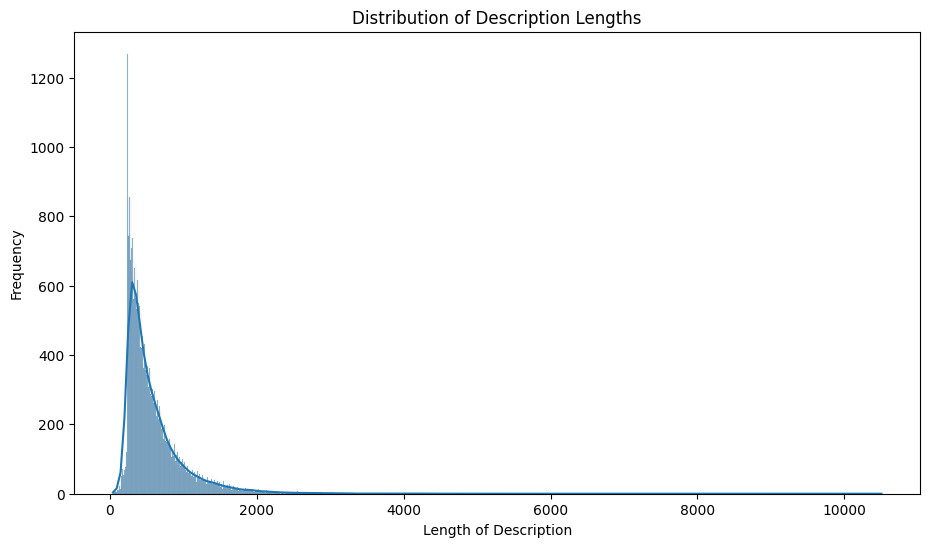

In [17]:
# Calculate description lengths in train data
train_data['Length'] = train_data['Description'].apply(len)

# Plot histogram of description lengths
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_data['Length'], bins=2000, kde=True)
plt.title('Distribution of Description Lengths')
plt.xlabel('Length of Description')
plt.ylabel('Frequency')
plt.show()


# 5 Data Preprocessing

In [18]:
# Remove duplicates
train_data.drop_duplicates(subset=['Description'], keep='first', inplace=True)
test_data.drop_duplicates(subset=['Description'], keep='first', inplace=True)

# Define the list of English stop words
stop_words = set(nltk.corpus.stopwords.words('english'))

# Define function to check if text is primarily in English
def english(text, threshold=0.6):
    words = nltk.word_tokenize(text.lower())
    english_word_count = sum(1 for word in words if word in stop_words or word.isalpha())
    english_ratio = english_word_count / len(words)
    return english_ratio >= threshold

# Filter non-English descriptions
train_data['is_english'] = train_data['Description'].apply(english)
test_data['is_english'] = test_data['Description'].apply(english)
train_data = train_data[train_data['is_english']].drop(columns=['is_english'])
test_data = test_data[test_data['is_english']].drop(columns=['is_english'])

# Clean text
stemmer = LancasterStemmer()
# Create function that clean text
def clean_text(text):
    # convert text to lower case,replace hyphens, remove digits, remove mentions,
    # remove non-letter caracters, remove urls,remove single caracters surranded by space
    text = text.lower()
    text = re.sub('-', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')
    # tokenize text into words
    words = word_tokenize(text)
    text = ' '.join([stemmer.stem(word) for word in words if word not in stop_words and len(word) > 2])
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply text cleaning on description column
train_data['Description_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Description_cleaning'] = test_data['Description'].apply(clean_text)

# Remove short descriptions
train_data['Length_Description_cleaning'] = train_data['Description_cleaning'].apply(len)
test_data['Length_Description_cleaning'] = test_data['Description_cleaning'].apply(len)
train_data = train_data[train_data['Length_Description_cleaning'] >= 130]

# Give unique numeric value for each genre
le = LabelEncoder()
train_data['Genre_encoded'] = le.fit_transform(train_data['Genre'])
test_data['Genre_encoded'] = le.transform(test_data['Genre'])


# 7 Naive Bayes Model Training

### 7.1 Start Timer

In [19]:
# Start Naive Bayes Model timing
start_time_nb = time.time()

### 7.2 Text Vectorization using TF-IDF

In [20]:
# Text vectorization using TF-IDF with n-grams (unigrams, bigrams, and trigrams)
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
# Fitting the TF-IDF vectorizer
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['Description_cleaning'])
# Transforming cleaned test data into TF-IDF features
X_test_tfidf = tfidf_vectorizer.transform(test_data['Description_cleaning'])


### 7.3 Apply SMOTE to Balance Classes

In [21]:
# Apply SMOTE
smote = SMOTE()
# creates synthetic samples for underrepresented classes
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, train_data['Genre_encoded'])


### 7.4 Hyperparameter Tuning with GridSearchCV

In [22]:
# Hyperparameter tuning with GridSearchCV
# Defining a parameter grid to search over.
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
}
# The parameter grid, cross-validation setting (cv=5), and number of jobs to run in parallel (n_jobs=-1) are specified.
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print("Best Parameters from GridSearchCV: ", best_params)


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters from GridSearchCV:  {'alpha': 0.01}


### 7.5 Train the Naive Bayes Classifier with Best Hyperparameters

In [23]:
# Train the Naive Bayes Classifier with the best hyperparameters
nb_classifier_smote = MultinomialNB(alpha=best_params['alpha'])
nb_classifier_smote.fit(X_train_smote, y_train_smote)


MultinomialNB(alpha=0.01)

### 7.6 Cross-Validation

In [24]:
# Perform cross-validation
cross_val_scores = cross_val_score(nb_classifier_smote, X_train_smote, y_train_smote, cv=5)
print("Cross-Validation Scores: ", cross_val_scores)
print("Mean Cross-Validation Score: ", cross_val_scores.mean())


Cross-Validation Scores:  [0.89749265 0.9162893  0.92240488 0.92719542 0.92524426]
Mean Cross-Validation Score:  0.9177253010683437


### 7.7 Predict on Test Set

In [25]:
# Predict on the test set
y_test_pred = nb_classifier_smote.predict(X_test_tfidf)


### 7.8 Calculate and Print Overall Running Time

In [26]:
# Capture the end time
end_time_nb = time.time()

# Calculate the overall running time
overall_time_nb = end_time_nb - start_time_nb

# Print the overall running time
print(f"Total running time: {overall_time_nb:.2f} seconds.")


Total running time: 325.16 seconds.


### 7.9 Evaluate the Classifier on the Test Set

In [27]:
# Evaluate the classifier on the test set
print("Test Accuracy: ", accuracy_score(test_data['Genre_encoded'], y_test_pred))
print("Classification Report on Test Set: \n", classification_report(test_data['Genre_encoded'], y_test_pred))


Test Accuracy:  0.5330741460705359
Classification Report on Test Set: 
               precision    recall  f1-score   support

           0       0.35      0.42      0.38      1313
           1       0.47      0.30      0.37       589
           2       0.31      0.20      0.25       772
           3       0.24      0.13      0.17       496
           4       0.06      0.03      0.04       263
           5       0.51      0.56      0.53      7426
           6       0.12      0.09      0.10       505
           7       0.70      0.74      0.72     13072
           8       0.60      0.58      0.59     13555
           9       0.24      0.17      0.19       770
          10       0.16      0.08      0.11       321
          11       0.93      0.54      0.68       191
          12       0.10      0.05      0.07       243
          13       0.52      0.58      0.55      2199
          14       0.46      0.61      0.52       712
          15       0.13      0.04      0.07       273
         

### 7.10 Predict on Training Set

In [28]:
# Predict on the train set
y_train_pred = nb_classifier_smote.predict(X_train_tfidf)
print("Training Accuracy: ", accuracy_score(train_data['Genre_encoded'], y_train_pred))
print("Classification Report on Training Set: \n", classification_report(train_data['Genre_encoded'], y_train_pred))


Training Accuracy:  0.7358305357598602
Classification Report on Training Set: 
               precision    recall  f1-score   support

           0       0.64      0.80      0.71      1238
           1       0.89      0.94      0.91       544
           2       0.78      0.80      0.79       736
           3       0.83      0.89      0.86       474
           4       0.76      0.92      0.83       258
           5       0.69      0.68      0.69      6926
           6       0.74      0.94      0.83       470
           7       0.82      0.78      0.80     12590
           8       0.77      0.65      0.70     12718
           9       0.71      0.80      0.75       733
          10       0.84      0.93      0.88       298
          11       0.95      0.96      0.96       183
          12       0.77      0.98      0.86       231
          13       0.78      0.86      0.82      2056
          14       0.63      0.92      0.75       673
          15       0.89      0.97      0.93       262
 

### 7.11 Plot Accuracy Comparison

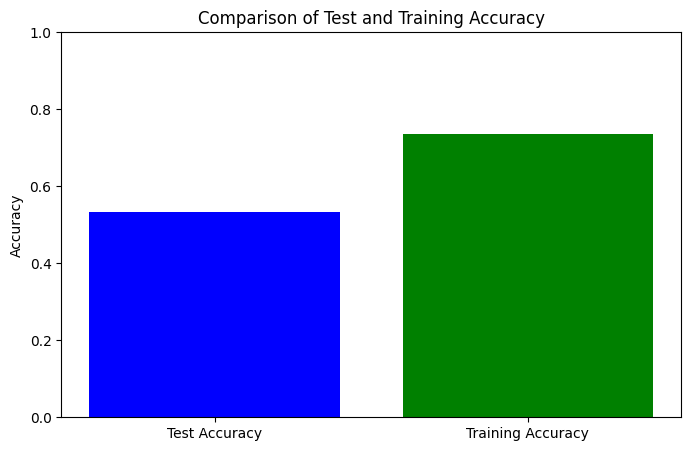

In [29]:
# Bar chart to compare both accuracy
labels = ['Test Accuracy', 'Training Accuracy']
accuracies = [accuracy_score(test_data['Genre_encoded'], y_test_pred), accuracy_score(train_data['Genre_encoded'], y_train_pred)]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Comparison of Test and Training Accuracy')
plt.ylim(0, 1)
plt.show()


### 7.12 Plot Confusion Matrix for Test Set

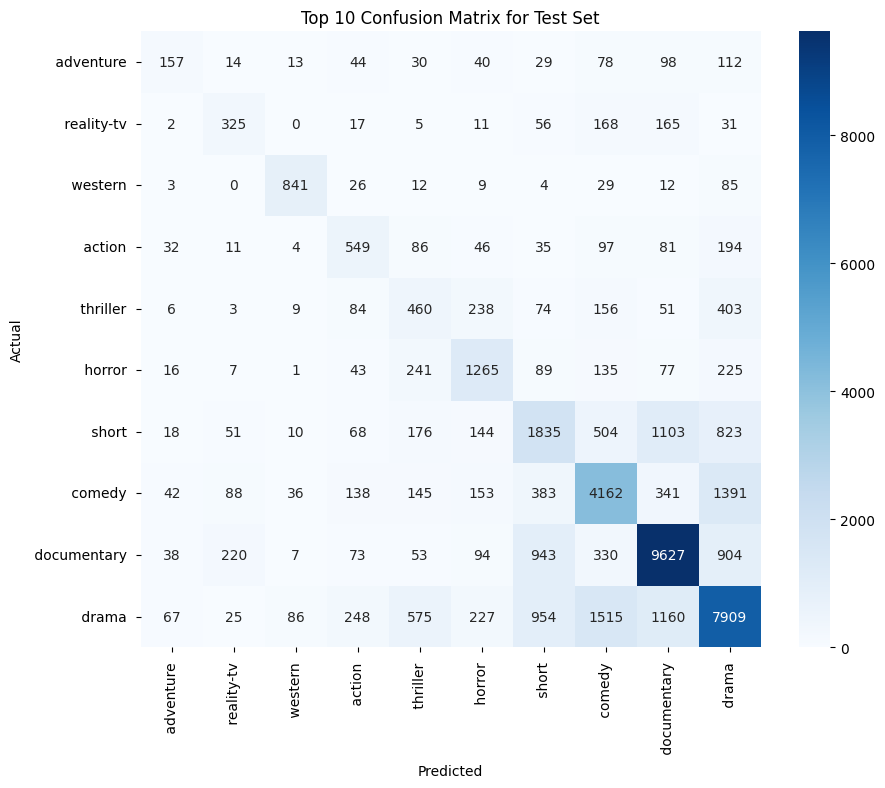

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure y_test_pred is in genre labels
encoded_to_genre = dict(zip(train_data['Genre_encoded'].unique(), train_data['Genre'].unique()))
y_test_pred_genre = [encoded_to_genre[pred] for pred in y_test_pred]

# Calculate the confusion matrix
cm = confusion_matrix(test_data['Genre'], y_test_pred_genre, labels=test_data['Genre'].unique())

# Sort and select top 10 classes by sum of occurrences in test set
class_counts = np.sum(cm, axis=1)
top_10_classes_indices = np.argsort(class_counts)[-10:]
top_10_classes = [test_data['Genre'].unique()[i] for i in top_10_classes_indices]

# Reduce confusion matrix to top 10 classes
cm_top_10 = cm[top_10_classes_indices][:, top_10_classes_indices]

# Create a heatmap for the top 10 confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_top_10, annot=True, fmt='d', cmap='Blues', xticklabels=top_10_classes, yticklabels=top_10_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Top 10 Confusion Matrix for Test Set')
plt.show()


# 8 RNN Model Training

### 8.1 Start Timer

In [31]:
# Start RNN Model timing
start_time_rnn = time.time()


### 8.2 Prepare Data for RNN

In [32]:
# Importing necessary modules from TensorFlow Keras for text preprocessing.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# maximum number of words to keep
num_words = 50000

# maximum length of the sequences
max_len = 250

# Initializing the Tokenizer 
tokenizer = Tokenizer(num_words=num_words, lower=True)

# Fitting the tokenizer on the cleaned descriptions from the training data.
tokenizer.fit_on_texts(train_data['Description_cleaning'].values)

# Converting the cleaned training descriptions to sequences of integers.
X = tokenizer.texts_to_sequences(train_data['Description_cleaning'].values)

# Padding the sequences to ensure they all have the same length (max_len).
X = pad_sequences(X, maxlen=max_len)

# Converting the genre labels in the training data to one-hot encoded format.
y = pd.get_dummies(train_data['Genre']).values

# Converting the cleaned test descriptions to sequences of integers using the same tokenizer.
X_test = tokenizer.texts_to_sequences(test_data['Description_cleaning'].values)

# Padding the test sequences to ensure they all have the same length (max_len).
X_test = pad_sequences(X_test, maxlen=max_len)

# Converting the genre labels in the test data to one-hot encoded format.
y_test = pd.get_dummies(test_data['Genre']).values


### 8.3 Define RNN Model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define RNN model
# Defining the embedding dimension
EMBEDDING_DIM = 100

# Initializing the Sequential model.
model = Sequential()
# Adding an Embedding layer to the model.
model.add(Embedding(num_words, EMBEDDING_DIM, input_length=X.shape[1]))
# Adding a SpatialDropout1D layer for regularization.
model.add(SpatialDropout1D(0.2))
# Adding an LSTM (Long Short-Term Memory) layer with 100 units.
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.2))
# Adding a Dense layer with 27 units (number of output classes) and softmax activation.
model.add(Dense(27, activation='softmax'))
# Compiling the model with categorical crossentropy loss function, Adam optimizer, and accuracy as a metric.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### 8.4 Define Callbacks and Train the Model

In [34]:
# Defining the EarlyStopping callback to stop training when a monitored metric has stopped improving.
# The training will stop if the validation loss ('val_loss') does not improve after 2 epochs ('patience' set to 2).
# 'min_delta' is set to 0, meaning any improvement in the monitored metric will be considered.
# 'mode' is set to 'auto', letting Keras automatically determine whether the monitored metric should be minimized or maximized.
my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

# Training the model with the training data (X, y).
# The training will run for a maximum of 6 epochs with a batch size of 32.
# The validation data (X_test, y_test) is used to evaluate the model's performance on unseen data during training.
# The EarlyStopping callback is passed to stop training early if the validation loss does not improve.
history = model.fit(X, y, epochs=6, batch_size=32,validation_data=(X_test,y_test), callbacks=my_callbacks)


Epoch 1/6
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 676s 421ms/step - accuracy: 0.3527 - loss: 2.2004 - val_accuracy: 0.5095 - val_loss: 1.6963
Epoch 2/6
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 665s 418ms/step - accuracy: 0.5602 - loss: 1.5349 - val_accuracy: 0.5502 - val_loss: 1.5400
Epoch 3/6
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 667s 419ms/step - accuracy: 0.6510 - loss: 1.2109 - val_accuracy: 0.5594 - val_loss: 1.5054
Epoch 4/6
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 666s 418ms/step - accuracy: 0.7253 - loss: 0.9455 - val_accuracy: 0.5522 - val_loss: 1.5845
Epoch 5/6
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 666s 419ms/step - accuracy: 0.7835 - loss: 0.7370 - val_accuracy: 0.5433 - val_loss: 1.7208


### 8.5 Calculate and Print Overall Running Time

In [35]:
# Capture the end time
end_time_rnn = time.time()

# Calculate the overall running time
overall_time_rnn = end_time_rnn - start_time_rnn

# Print the overall running time
print(f"Total running time: {overall_time_rnn:.2f} seconds.")



Total running time: 3348.62 seconds.


### 8.6 Predict on Test Set

In [36]:
# Predict the classes for the test set
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)
y_test_true = np.argmax(y_test, axis=1)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 152s 90ms/step


### 8.7 Print Accuracy and Classification Report

In [37]:
# Print the accuracy and classification report
print("Test Accuracy: ", accuracy_score(y_test_true, y_test_pred))
print("Classification Report on Test Set: \n", classification_report(y_test_true, y_test_pred))


Test Accuracy:  0.5433120429510321
Classification Report on Test Set: 
               precision    recall  f1-score   support

           0       0.35      0.27      0.31      1313
           1       0.42      0.43      0.43       589
           2       0.29      0.12      0.17       772
           3       0.24      0.11      0.16       496
           4       0.00      0.00      0.00       263
           5       0.54      0.50      0.52      7426
           6       0.19      0.10      0.13       505
           7       0.68      0.78      0.72     13072
           8       0.54      0.68      0.60     13555
           9       0.23      0.11      0.15       770
          10       0.15      0.01      0.02       321
          11       0.61      0.60      0.61       191
          12       0.10      0.00      0.01       243
          13       0.54      0.61      0.57      2199
          14       0.51      0.50      0.50       712
          15       0.24      0.06      0.10       273
         

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 8.8 Plot Confusion Matrix for Test Set

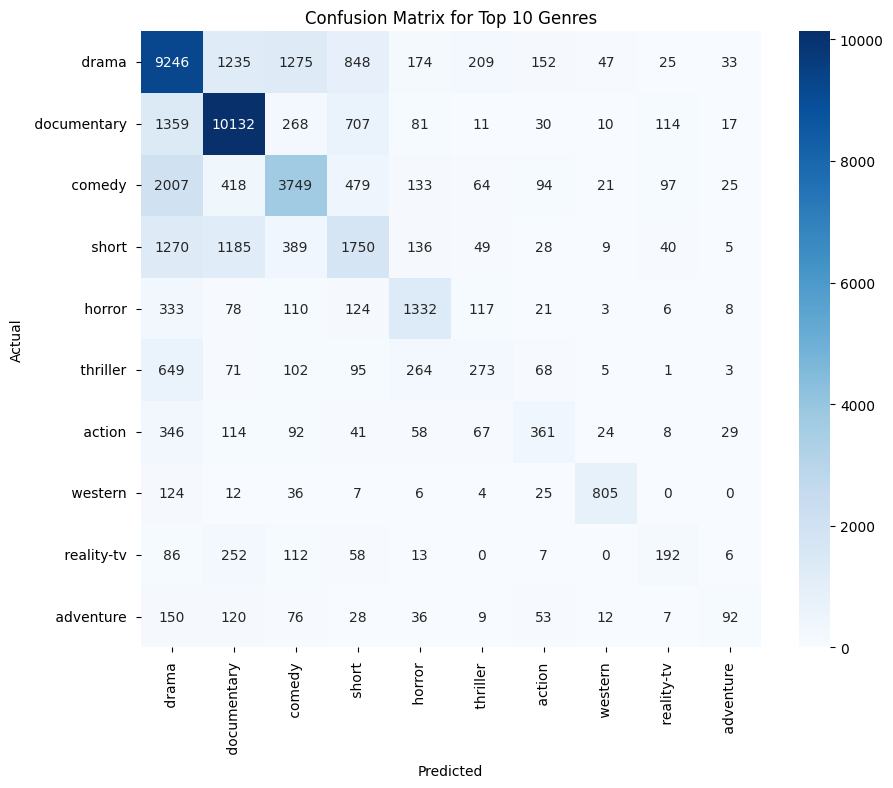

In [38]:
# Ensure both are the same type, e.g., integers
y_test_true = pd.Series(y_test_true).astype(int)
y_test_pred = pd.Series(y_test_pred).astype(int)

# Calculate the support (frequency) for each genre in the true labels
genre_counts = y_test_true.value_counts()

# Get the top 10 genres based on support
top_genres = genre_counts.nlargest(10).index

# Filter the true and predicted labels to include only the top 10 genres
mask = y_test_true.isin(top_genres)
y_test_true_top_genres = y_test_true[mask]
y_test_pred_top_genres = y_test_pred[mask]

# Create the confusion matrix for the top 10 genres
cm = confusion_matrix(y_test_true_top_genres, y_test_pred_top_genres, labels=top_genres)

# Get the genre names for the top genres
top_genre_names = le.inverse_transform(top_genres)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=top_genre_names, yticklabels=top_genre_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Top 10 Genres')
plt.show()

### 8.9 Plot Training History

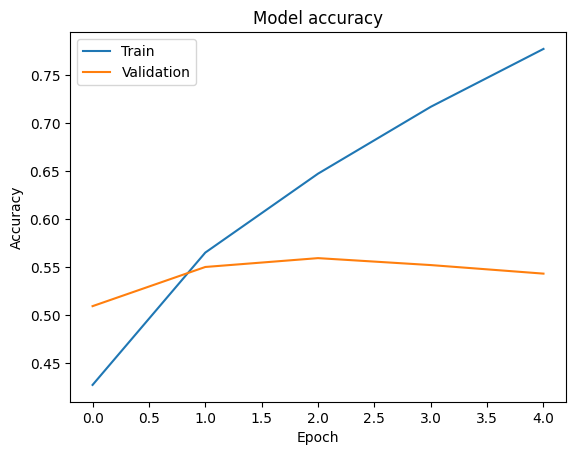

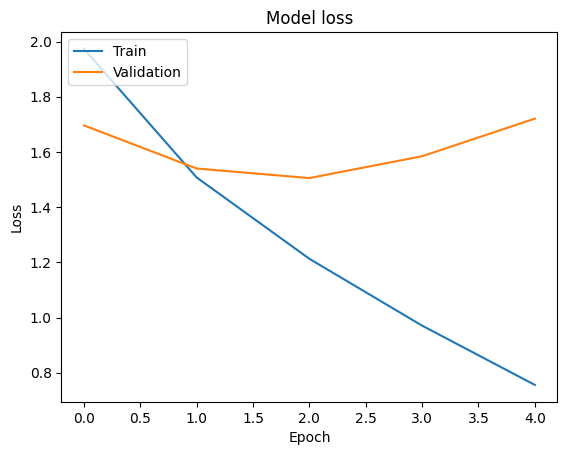

In [39]:
# Plot training history
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# 9 Comparison of Running Times

### 9.1 Define the Models and Their Running Times

In [40]:
# manul input form BERT notebook
overall_time_bert = 5862
# Define the models and their running times
models = ['BERT', 'Multinomial Naive Bayes', 'RNN']
running_times = [overall_time_bert, overall_time_nb, overall_time_rnn]


### 9.2 Create a Bar Plot to Compare Running Times

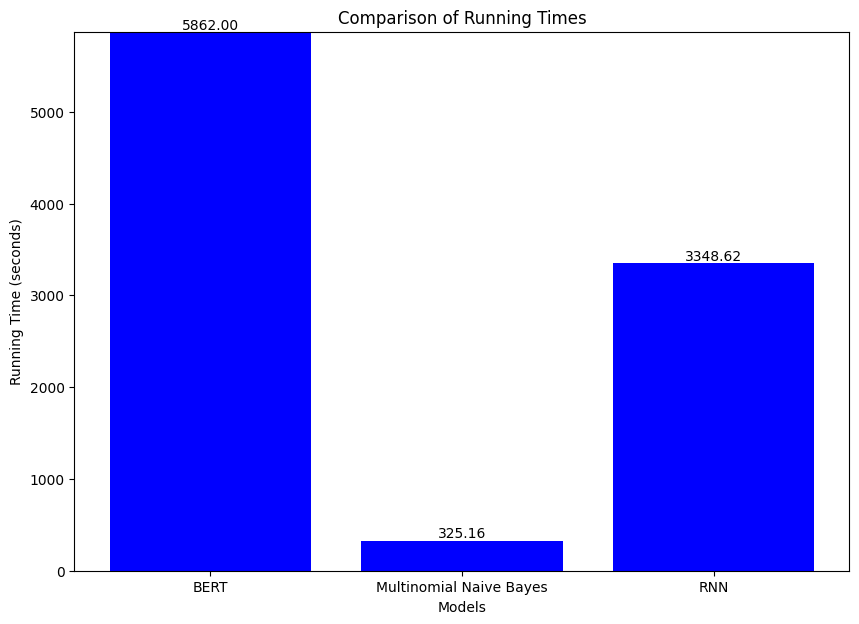

In [41]:
# Create a bar plot to compare running times
plt.figure(figsize=(10, 7))
bars = plt.bar(models, running_times, color='blue')
plt.title('Comparison of Running Times')
plt.xlabel('Models')
plt.ylabel('Running Time (seconds)')
plt.ylim(0, max(running_times) + 10)

# Add labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

